# Inference

Test the trained and saved on model on the images of the Red Sea. The images are stored in `"/data/jonathan/eilat_gopro/"`.

## Imports

In [15]:
# load custom scripts
from utils import *
import config 

# import the necessary packages
from imutils import paths
from skimage import io
from torchmetrics import ConfusionMatrix
from torchvision import transforms
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import torch
import torchmetrics

## Controlling sources of randomness

In [12]:
torch.manual_seed(0)
random.seed(0)
#np.random.seed(0)

## Plot function

In [13]:
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

In [53]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)
confmat = ConfusionMatrix(num_classes=10)

In [77]:
def prepare_plot(image, gtLabel, predLabel):

    # plot the original image, its mask, and the predicted mask
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
    im1 = ax[0].imshow(unnormalize(image[0]).cpu().detach().permute(1, 2, 0))
    im2 = ax[1].imshow(gtLabel.numpy(),
                       cmap = plt.cm.get_cmap('tab20', 10),
                       vmin=0, vmax=9)
    im3 = ax[2].imshow(predLabel.numpy(),
                       cmap = plt.cm.get_cmap('tab20', 10),
                       vmin=0, vmax=9)

    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Original Labels")
    ax[2].set_title("Predicted Labels")

    # add colour bar
    cbar = fig.colorbar(im3, ticks=list(classes.keys()), fraction=0.045)
    cbar.ax.set_yticklabels(list(classes.values()))

    # set the layout of the figure and display it
    plt.show()
    
    print("[INFO] Accuracy {}".format(acc(gtLabel, predLabel)))
    cf_matrix = np.array(confmat(gtLabel, predLabel))

    # confusion matrix
    fig, ax = plt.subplots(figsize=(15,15))
    ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                     fmt='.2%', cmap='Blues', linewidths=.5, ax=ax)

    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Category')
    ax.set_ylabel('Actual Category ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(list(classes.values()),rotation = 30)
    ax.yaxis.set_ticklabels(list(classes.values()),rotation = 30)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [78]:
scene = 'scene_0'

## Testing loop

In [79]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk
        image = io.imread(imagePath)
        
        # load the labels from disk
        groundTruthPath = '/data/jantina/CoralNet/inference/labels/'+scene+'/' + imagePath.split(os.path.sep)[-1]+'.tif'
        gtLabel = io.imread(groundTruthPath)
    
        # apply transformation
        transformed = test_transform(image=image, mask=gtLabel)
        image = transformed["image"]
        gtLabel = transformed["mask"]
        
        # create image tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image)
        image = image.to("cuda")
        
        # create mask tensor
        asarray = lambda x: torch.tensor(np.array(x), dtype=torch.long)
        gtLabel = asarray(np.expand_dims(gtLabel, 0))

        # prediction
        predLabel = model(image).squeeze()
        predLabel = torch.argmax(predLabel, dim=0)
        predLabel = predLabel.cpu()
        
        # prepare a plot for visualization
        prepare_plot(image, gtLabel.squeeze(), predLabel)

In [80]:
test_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33)),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

## Make predictions

[INFO] loading up test image paths...
[INFO] load up model...


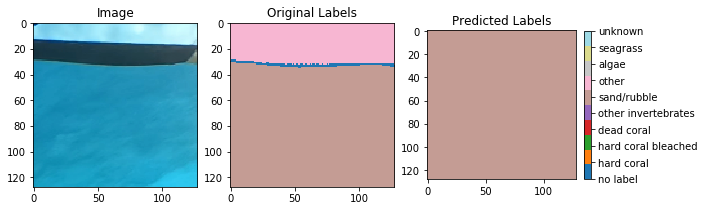

[INFO] Accuracy 0.73565673828125


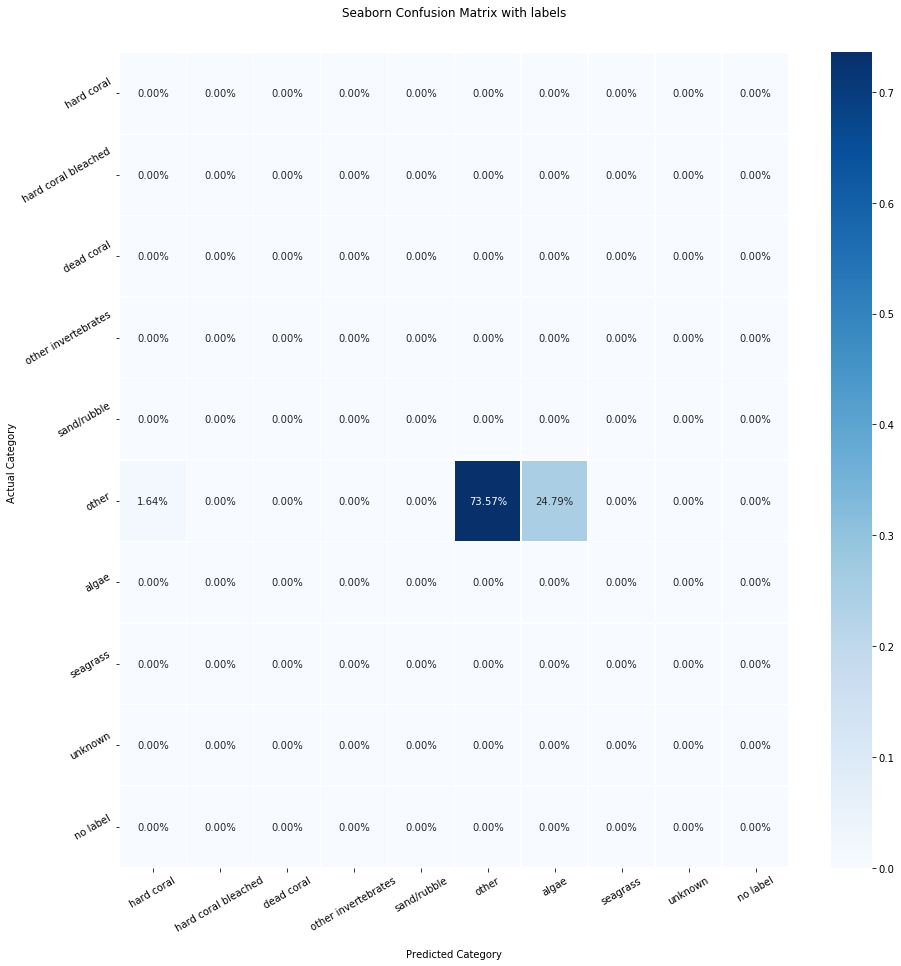

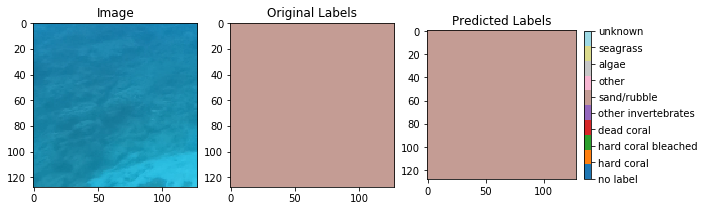

[INFO] Accuracy 1.0


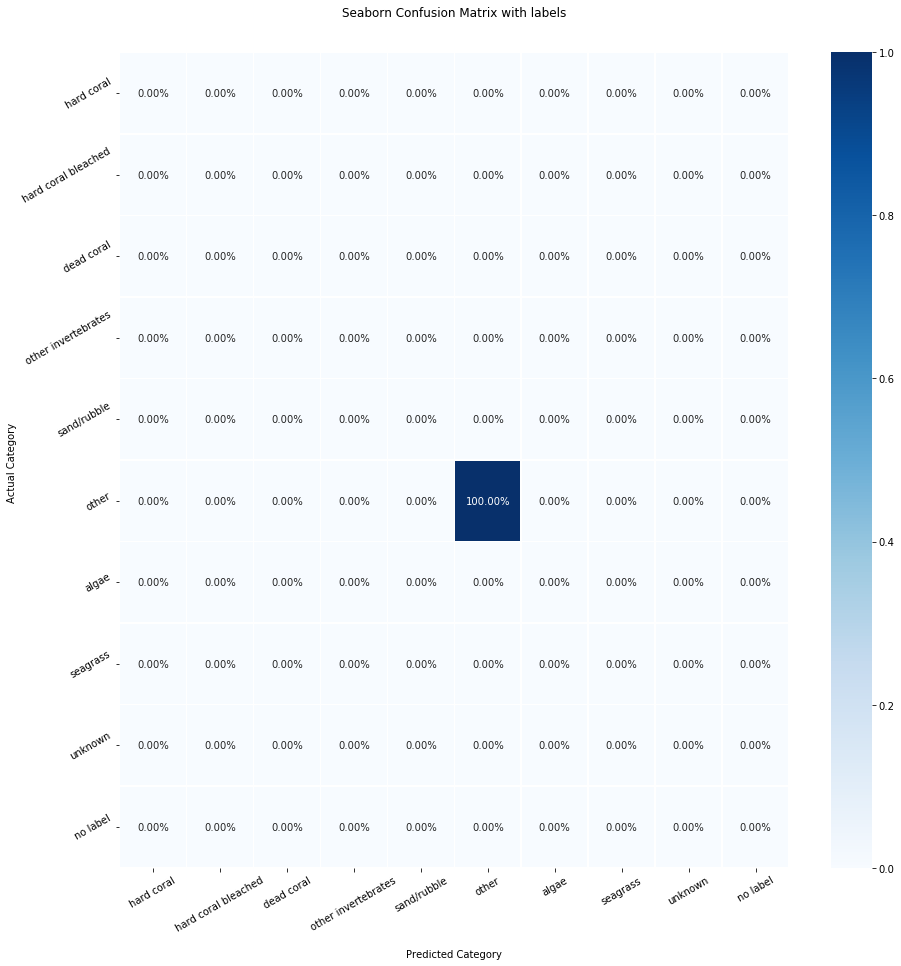

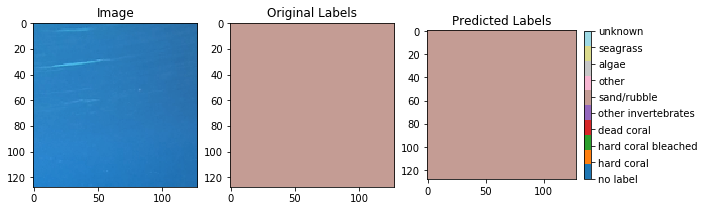

[INFO] Accuracy 1.0


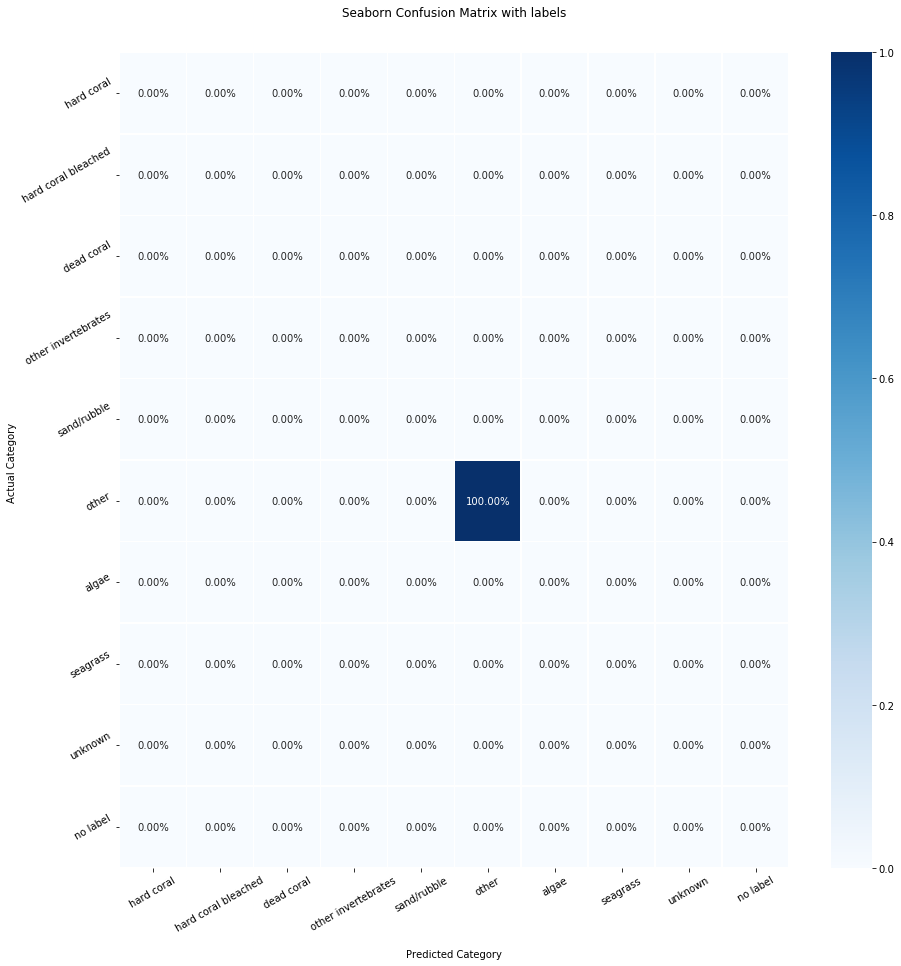

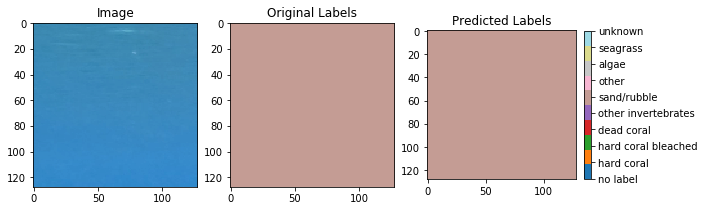

[INFO] Accuracy 1.0


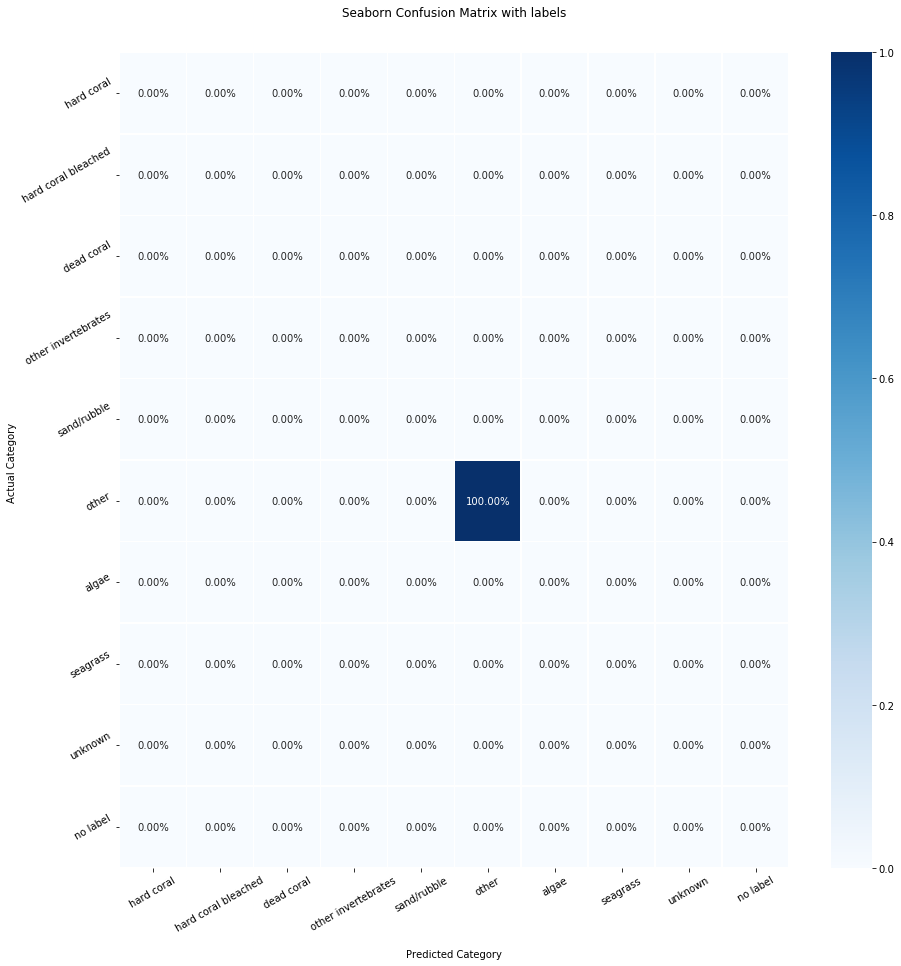

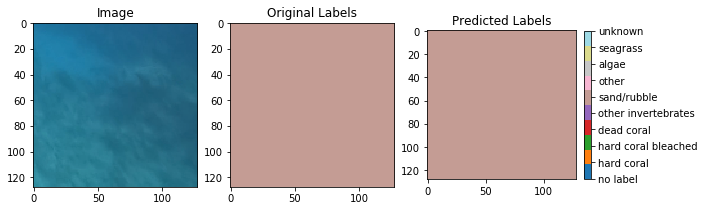

[INFO] Accuracy 1.0


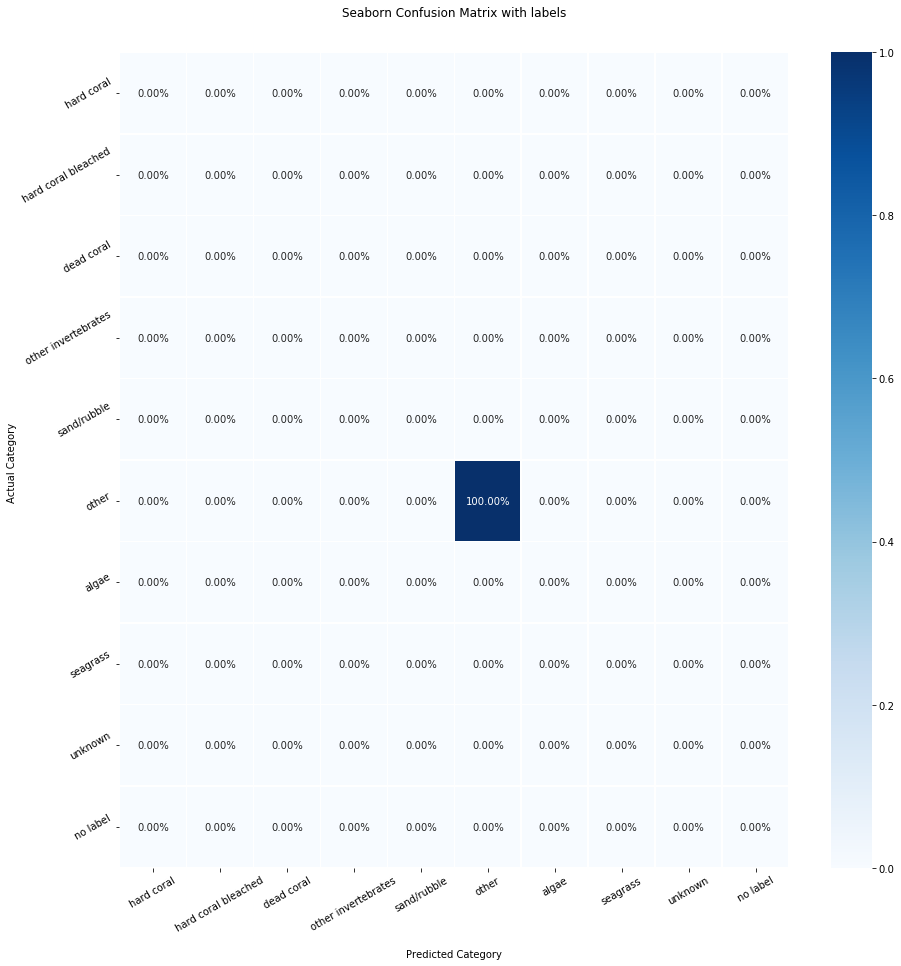

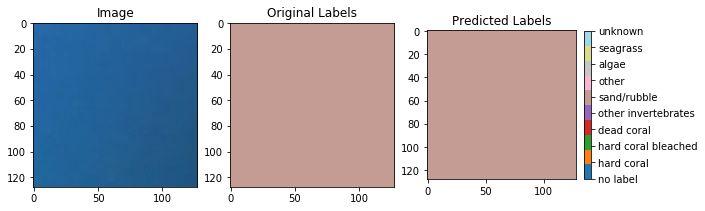

[INFO] Accuracy 1.0


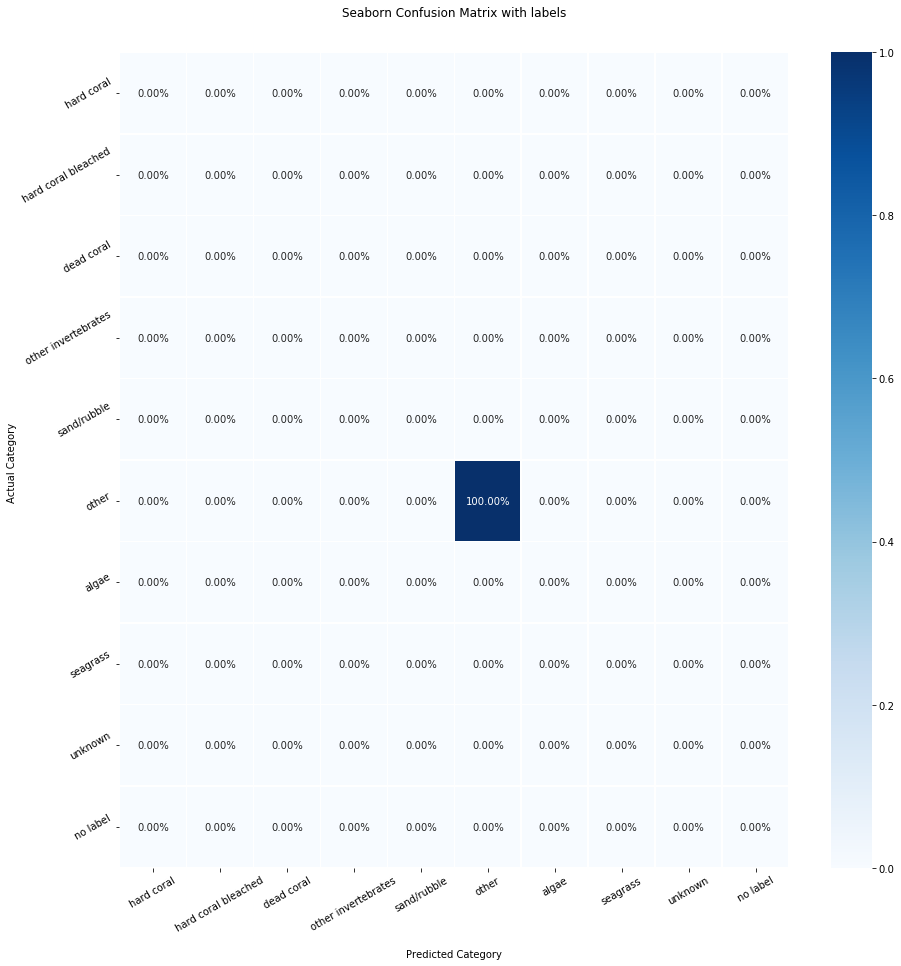

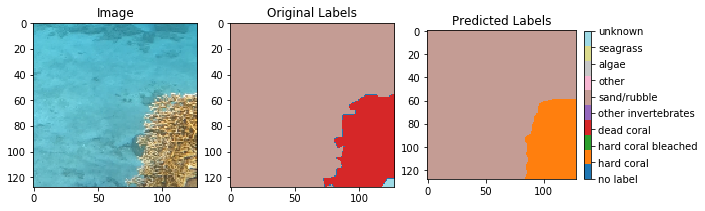

[INFO] Accuracy 0.81744384765625


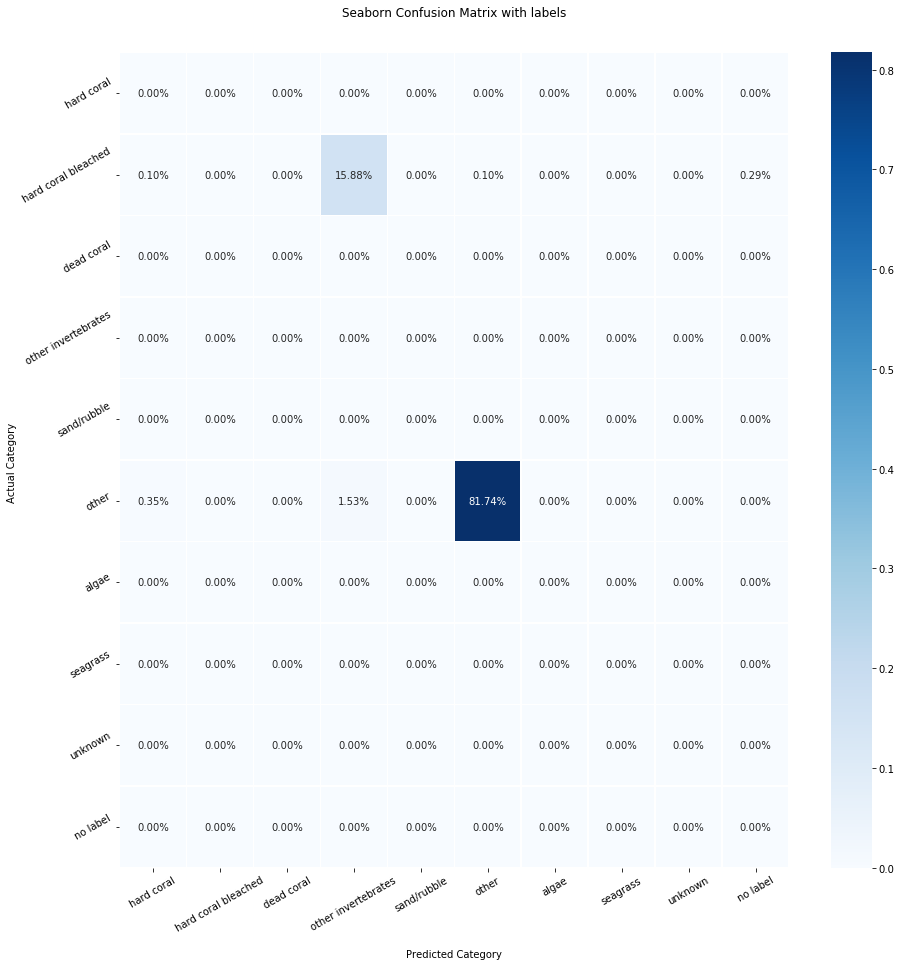

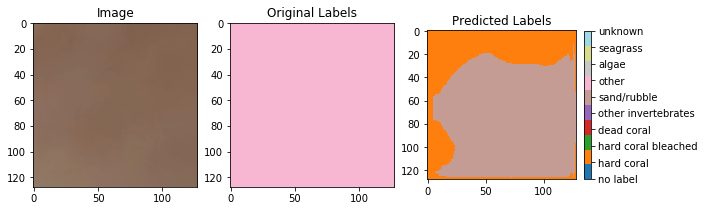

[INFO] Accuracy 0.0


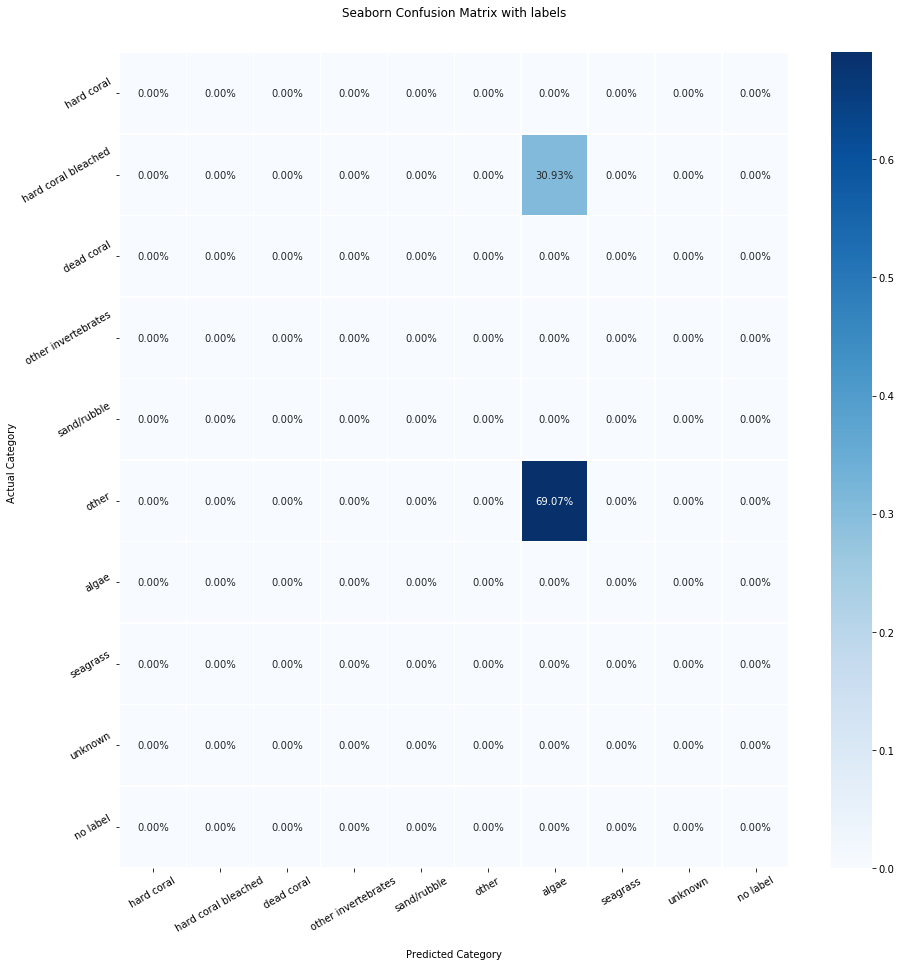

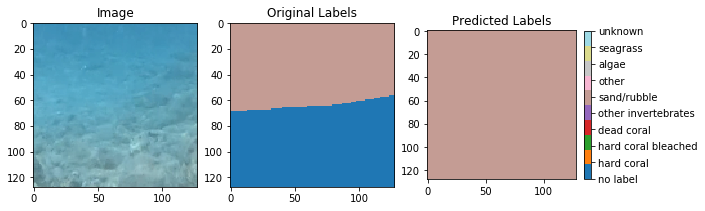

[INFO] Accuracy 0.50384521484375


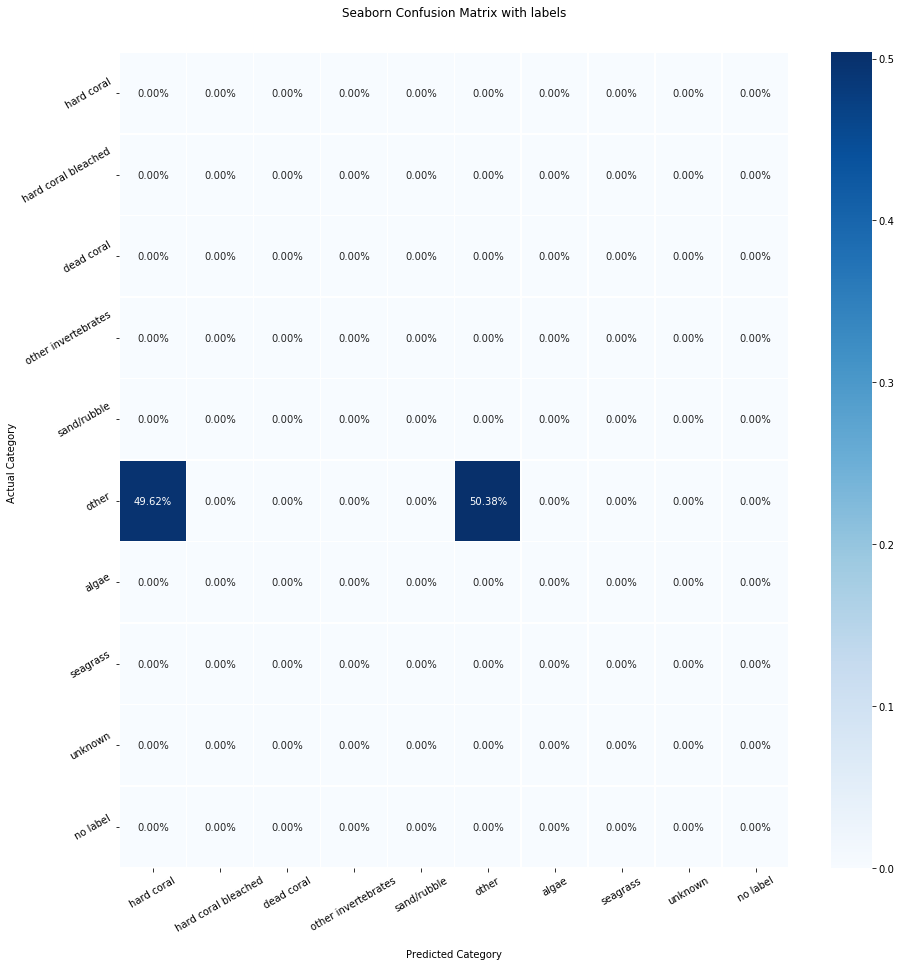

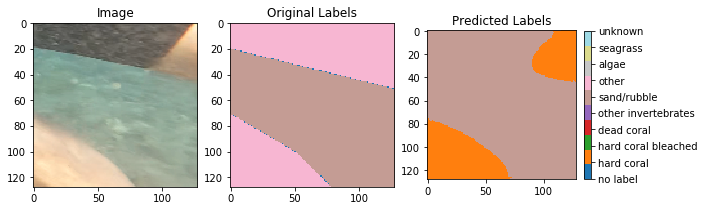

[INFO] Accuracy 0.56005859375


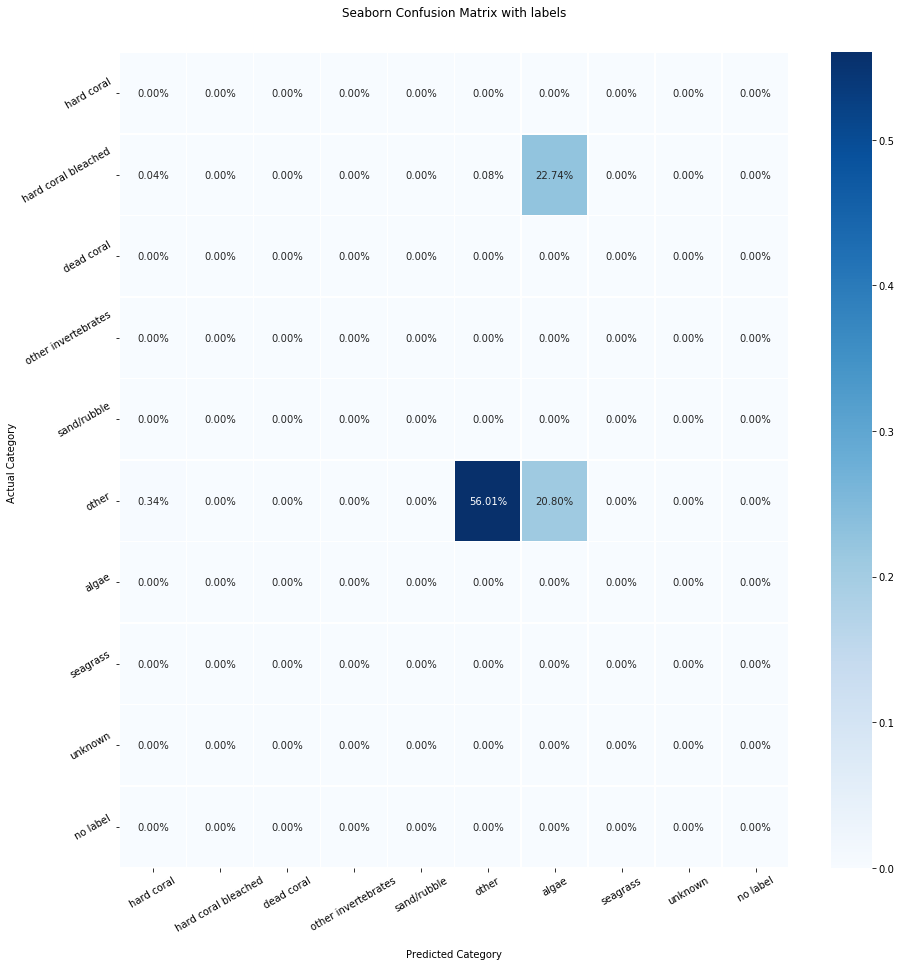

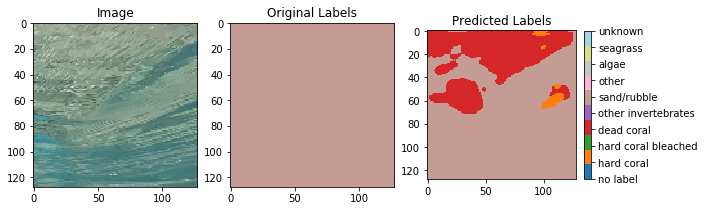

[INFO] Accuracy 0.7117919921875


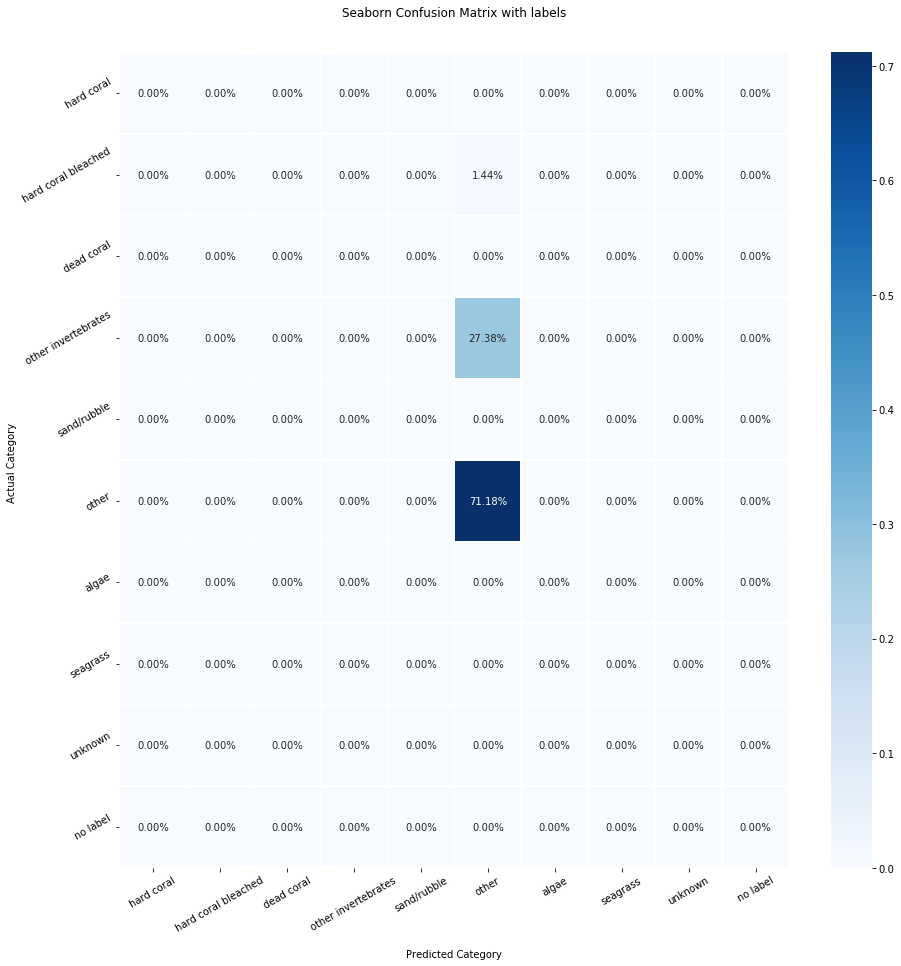

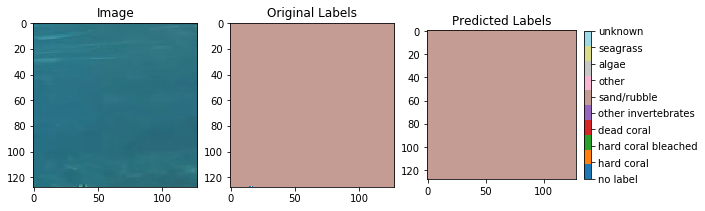

[INFO] Accuracy 0.99981689453125


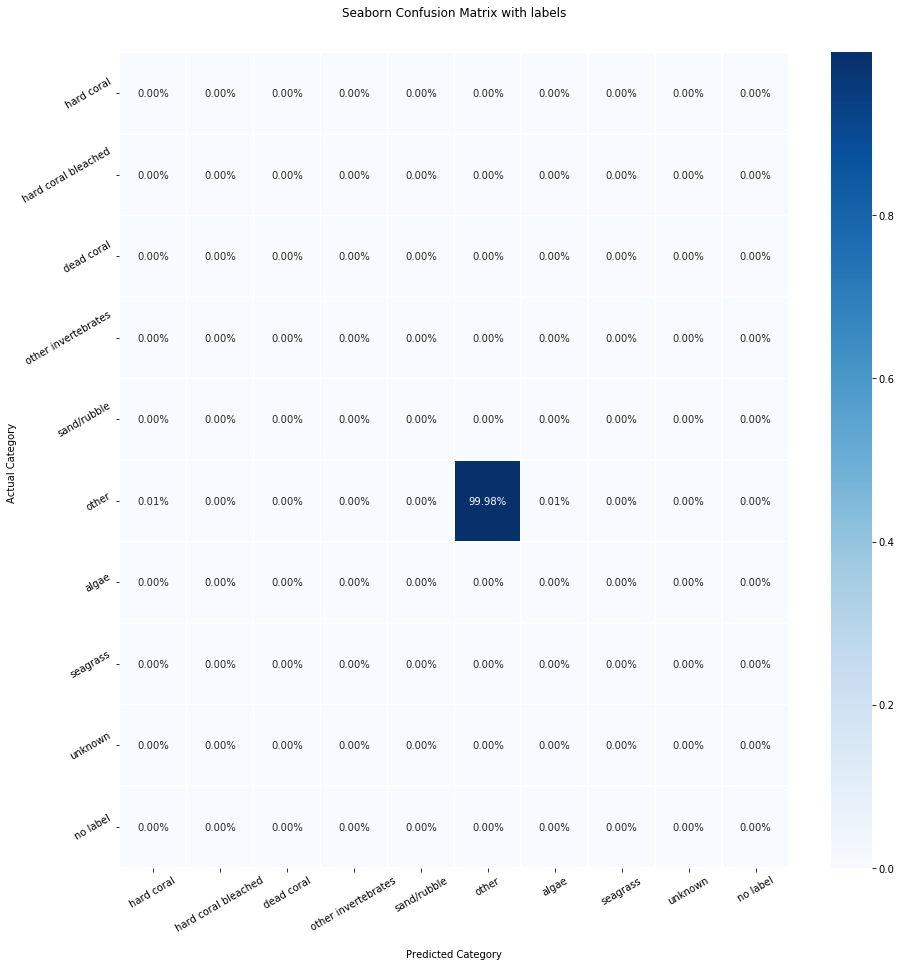

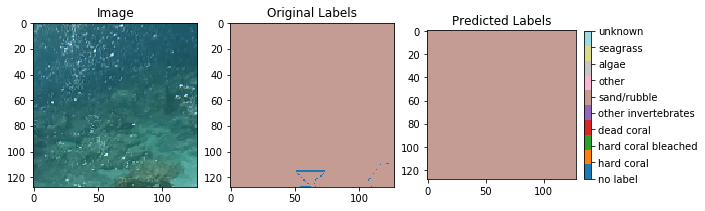

[INFO] Accuracy 0.99676513671875


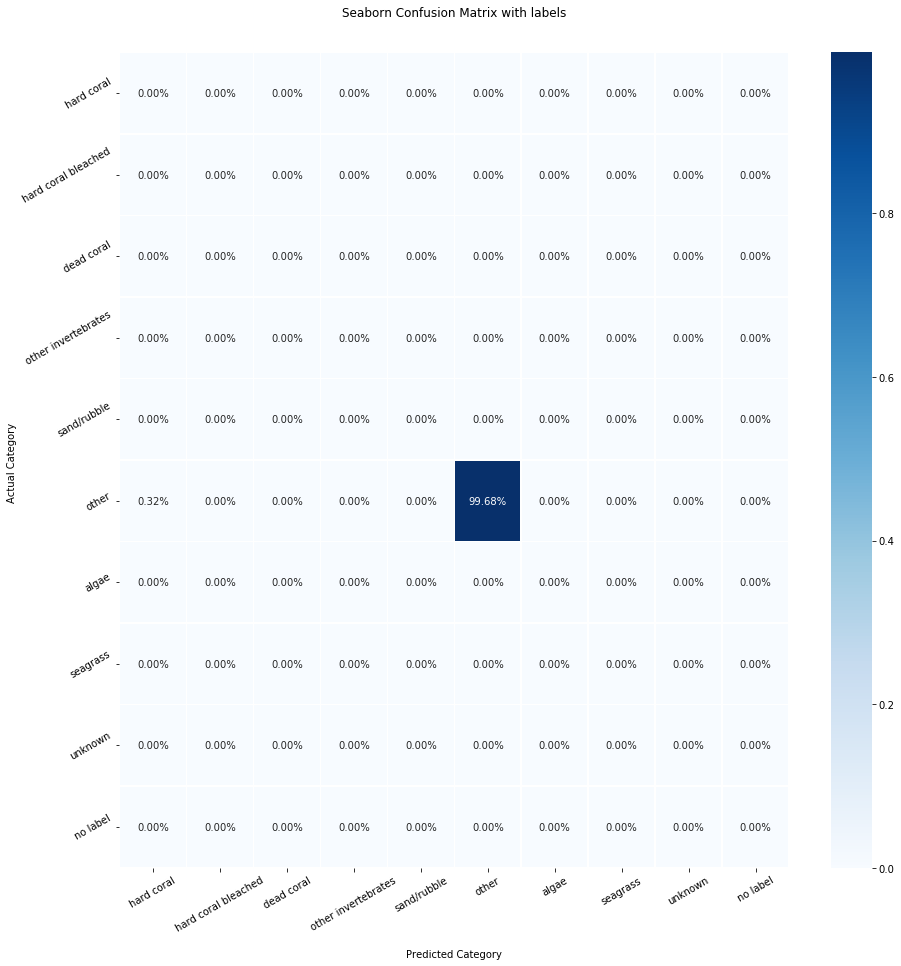

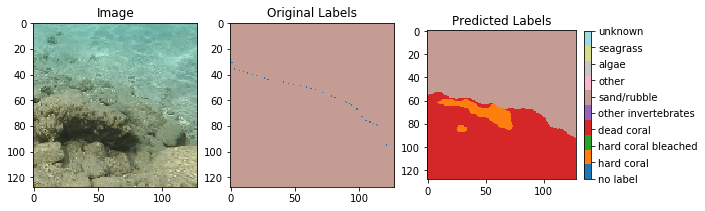

[INFO] Accuracy 0.52545166015625


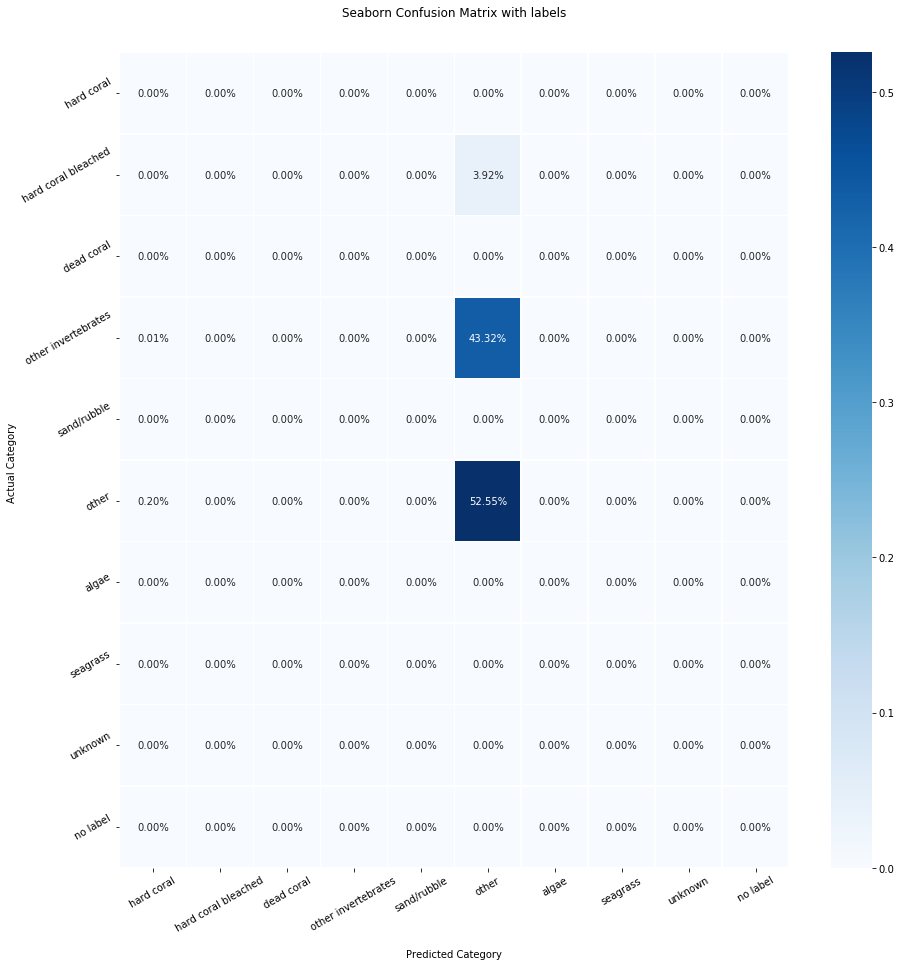

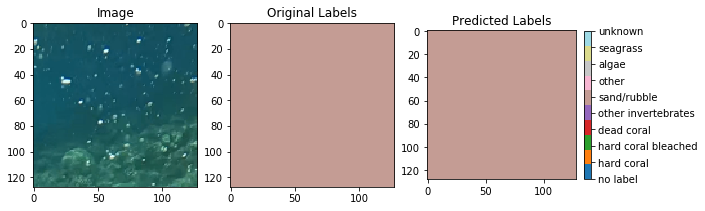

[INFO] Accuracy 1.0


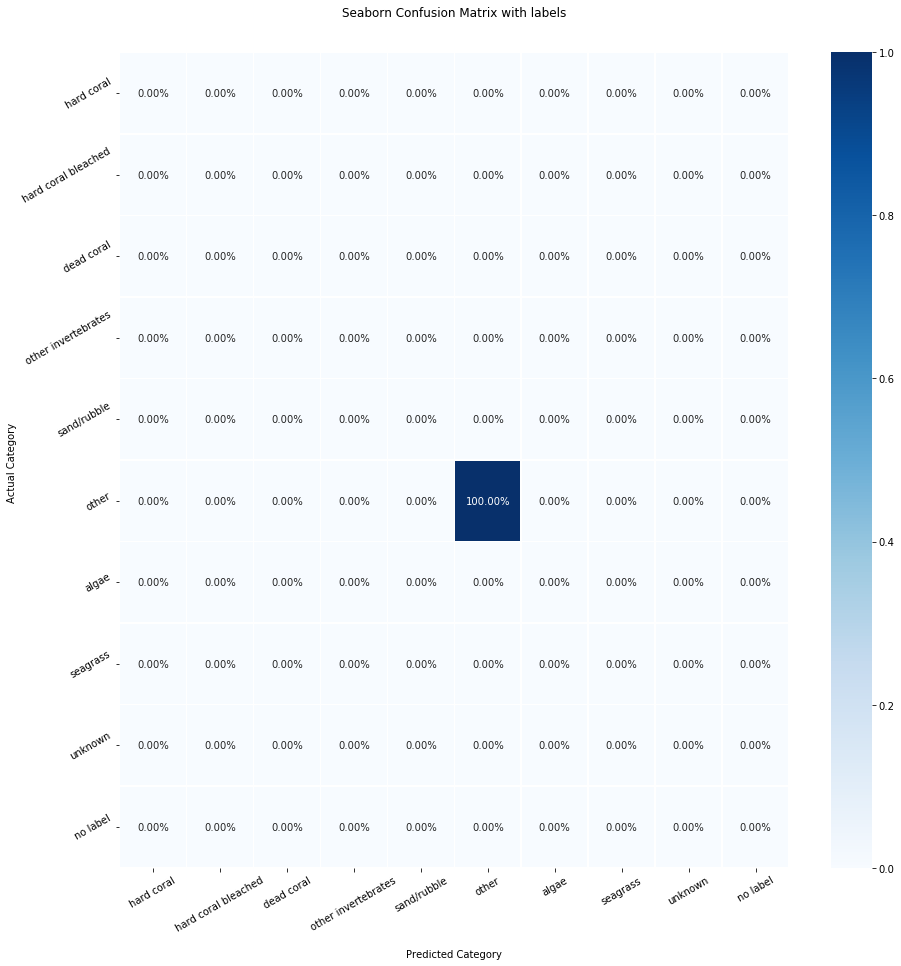

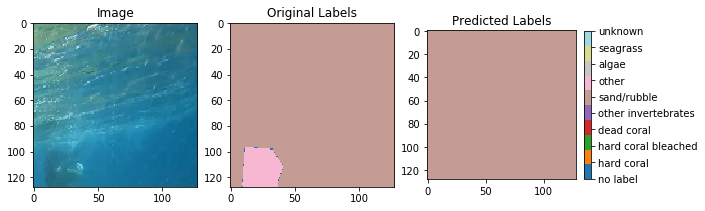

[INFO] Accuracy 0.94854736328125


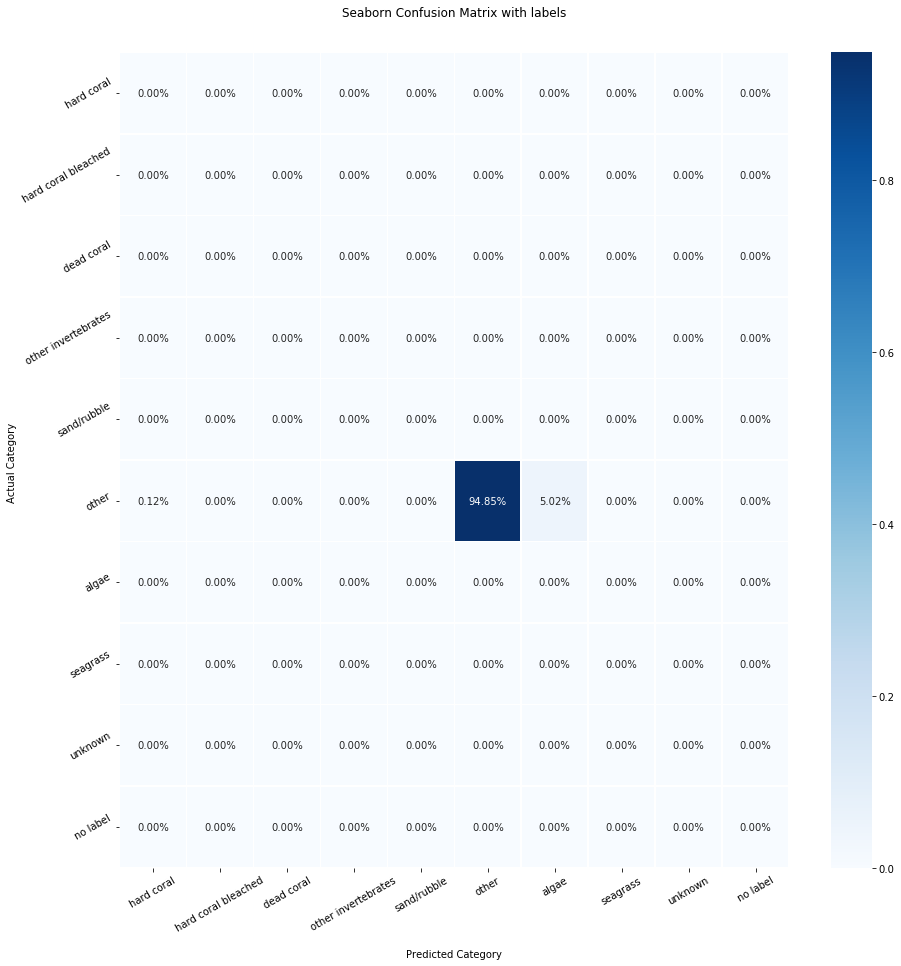

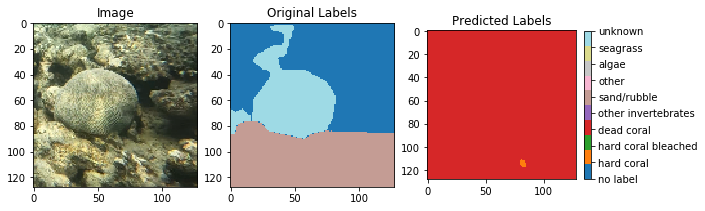

[INFO] Accuracy 0.0


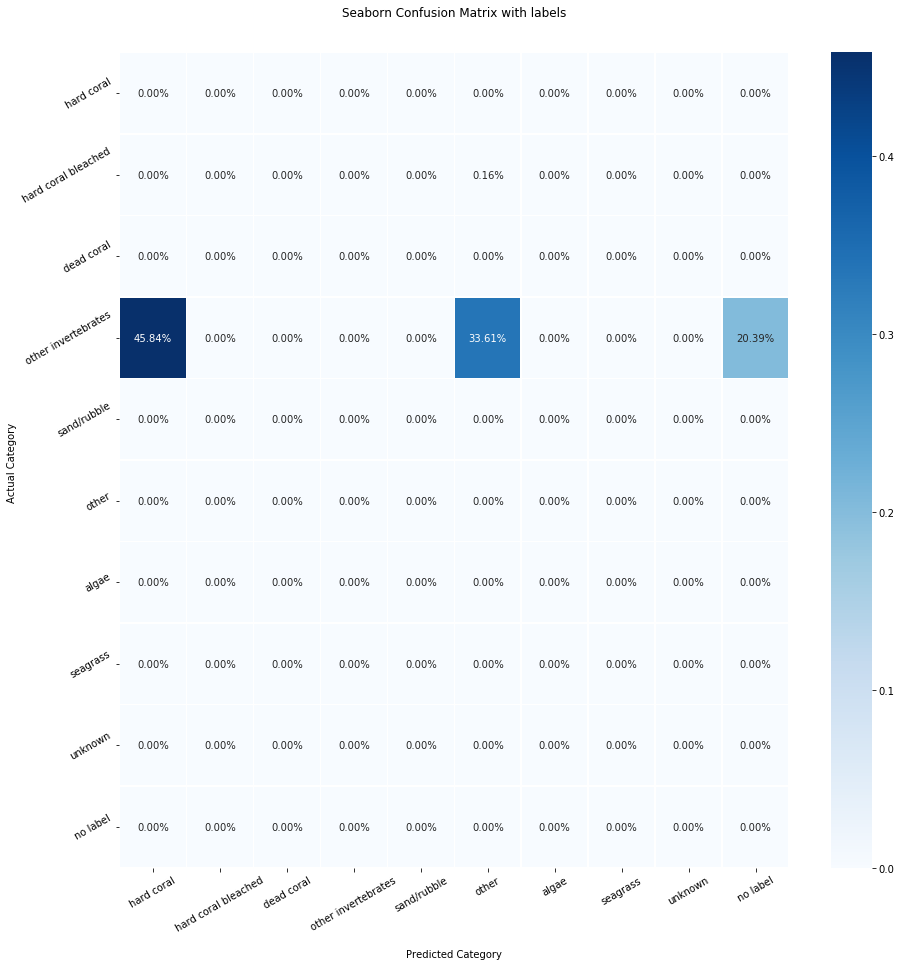

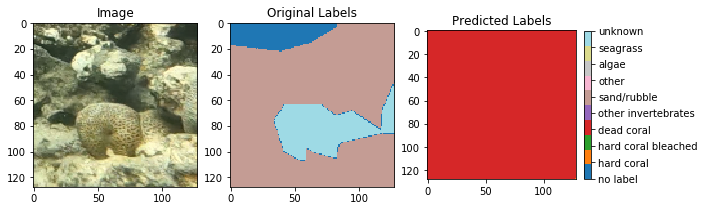

[INFO] Accuracy 0.0


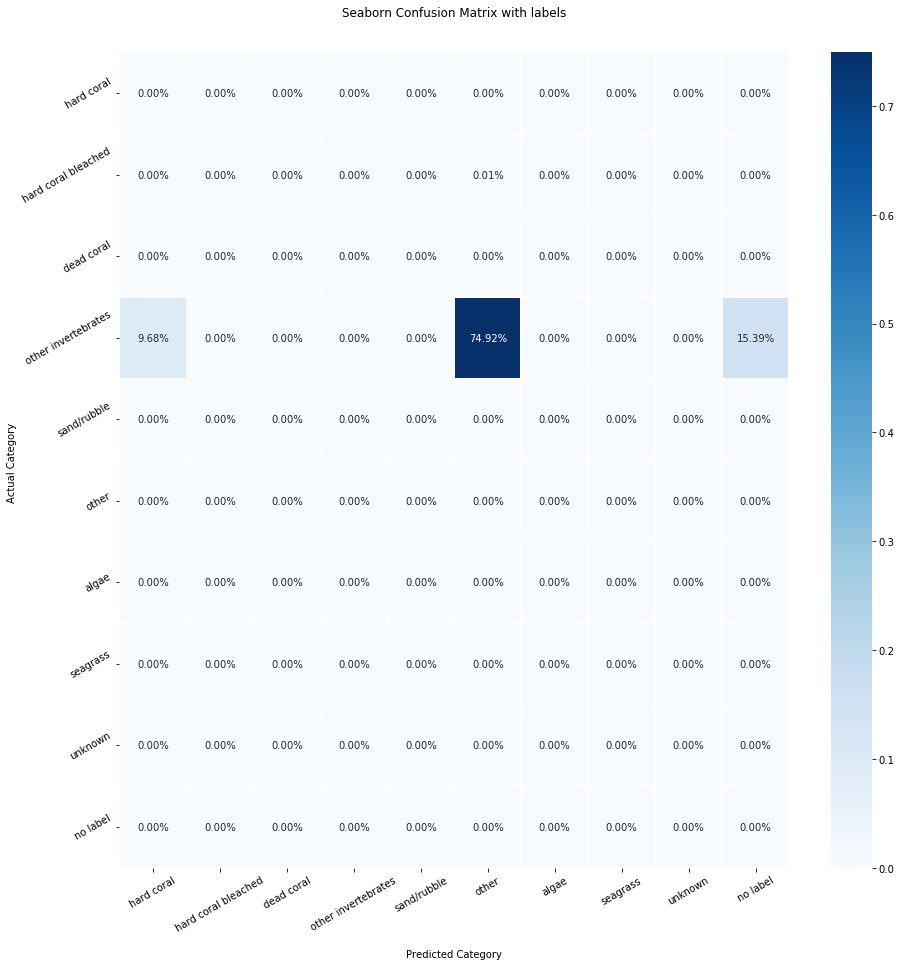

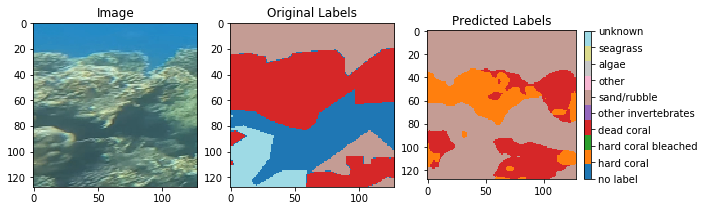

[INFO] Accuracy 0.35296630859375


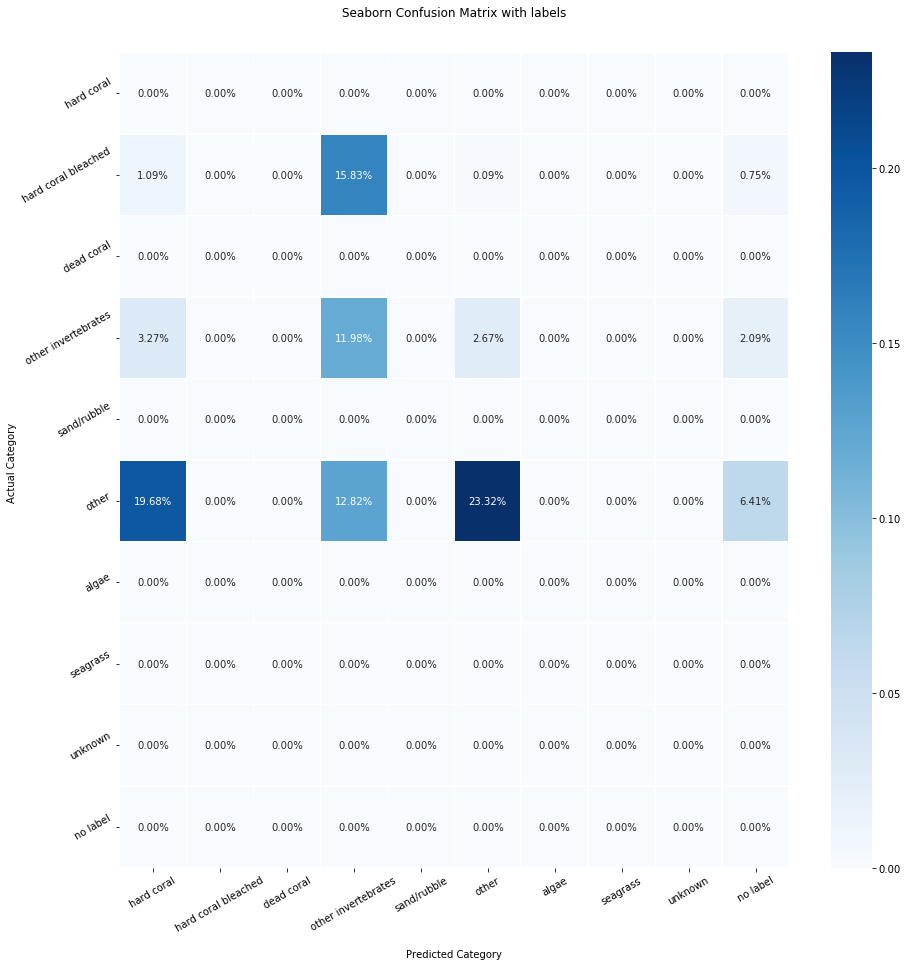

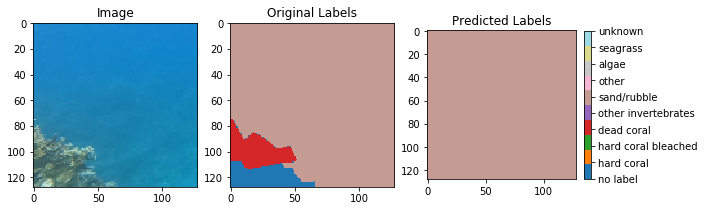

[INFO] Accuracy 0.88189697265625


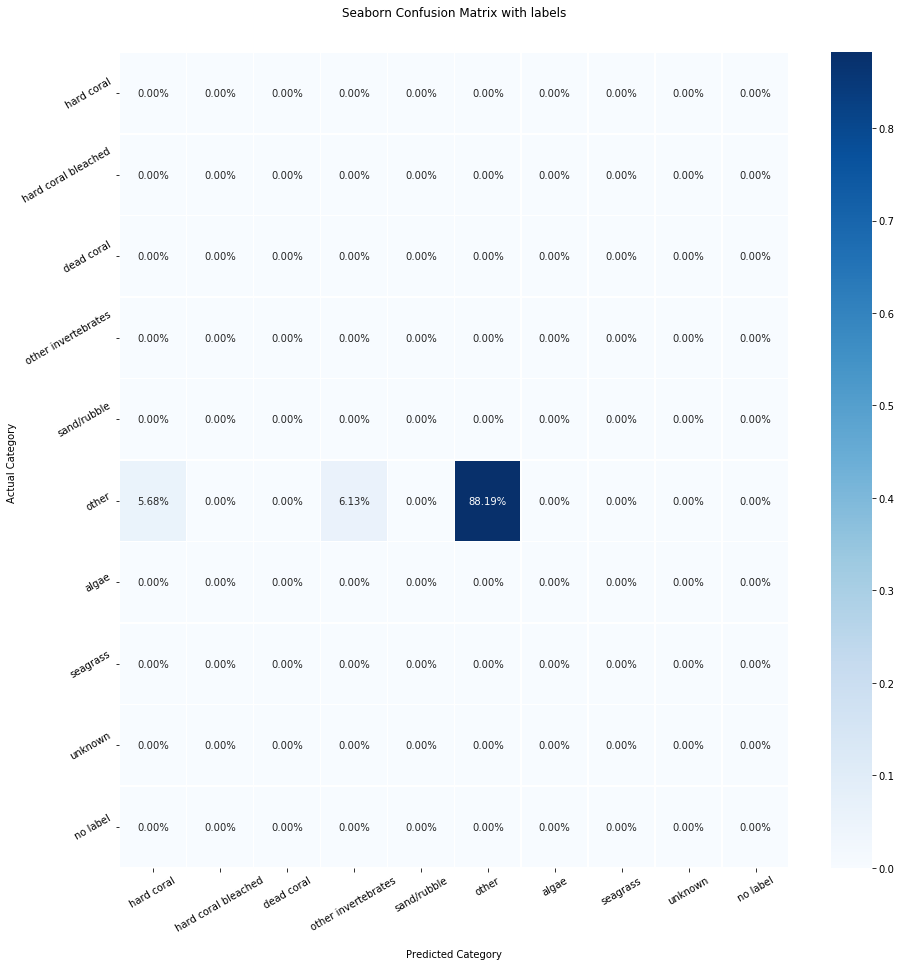

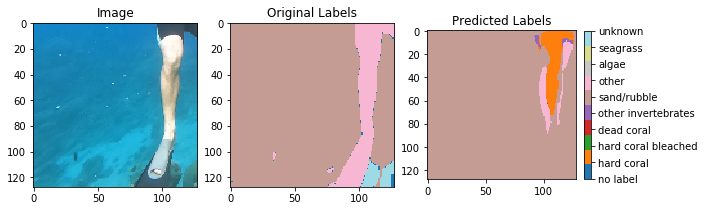

[INFO] Accuracy 0.83514404296875


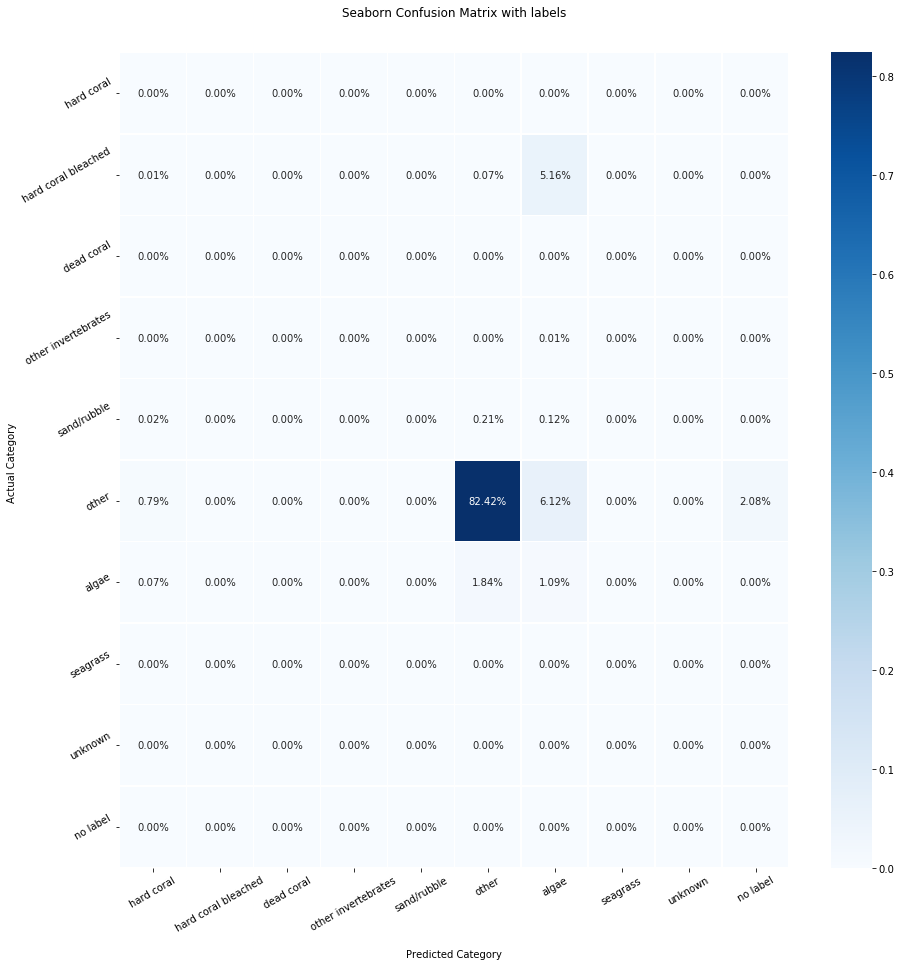

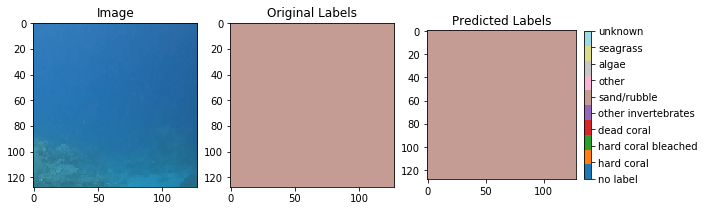

[INFO] Accuracy 1.0


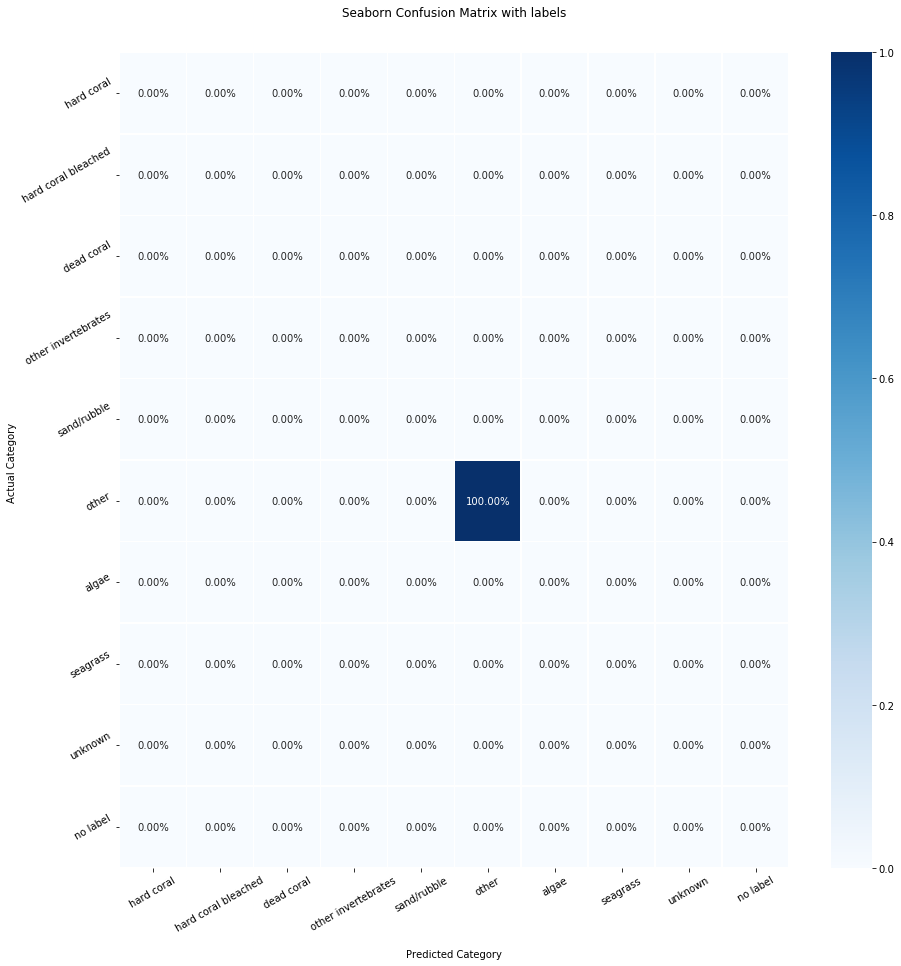

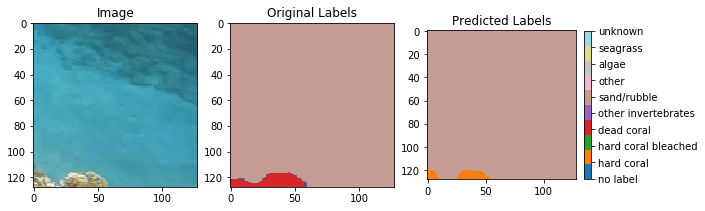

[INFO] Accuracy 0.9716796875


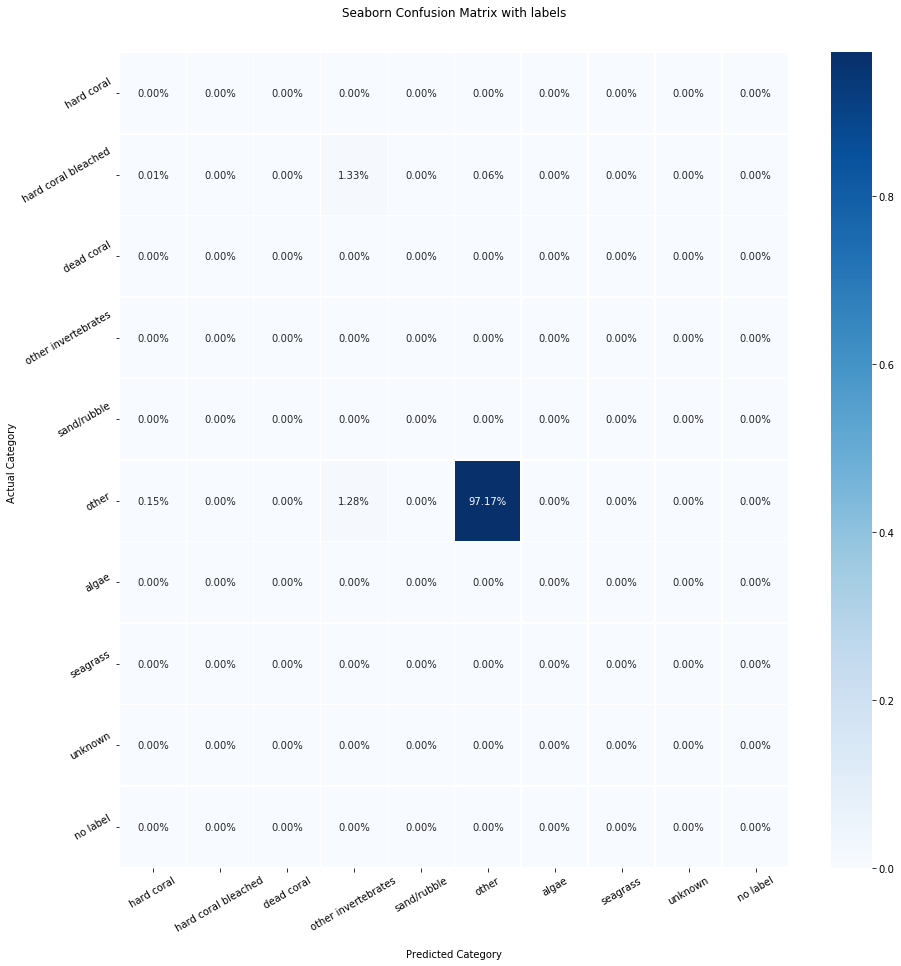

In [81]:
# load the image paths corresponding to the images
print("[INFO] loading up test image paths...")
directory = "/data/jantina/CoralNet/inference/images/"+scene+"/"

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load(config.MODEL_PATH).to(config.DEVICE)

for path in os.listdir(directory):
    imagePath = os.path.join(directory, path)
    make_predictions(unet, imagePath)